# PREDICT THE CRYPTOCURRENCY PRICE

In [3]:
## Loading the required libraries and dependencies
#===============================================
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [53]:
## Data set
#===============================================
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=1000') # Getting the Bitcoin price history against USD, limit will increase the number of days
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s') # To convert string Date time into Python Date time object
target_col = 'close'

In [54]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [55]:
## To look at the data set with headings
#===========================================
hist.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2019-07-27,10202.95,9310.47,9847.45,53081.42,5.126121e+08,9478.32
2019-07-28,9591.52,9135.64,9478.32,28313.55,2.672438e+08,9531.77
2019-07-29,9717.69,9386.90,9531.77,31434.40,2.999364e+08,9506.93
2019-07-30,9749.53,9391.78,9506.93,28856.19,2.764023e+08,9595.52
2019-07-31,10123.94,9581.60,9595.52,42030.01,4.163431e+08,10089.25


The dataset contains total of 6 features. The details for them are as follows:
High Price — It is highest price of currency for the day.
Low Price — It is the lowest price for currency for that day.
Open Price — It is market open price for currency for that day.
Volume from and to — The volume of currency that is being in trade for that day.
Close Price — It is the market close price for currency for that particular day.

In [57]:
## Splitting data into two sets — training set and test set with 80% and 20%
#==================================================
def train_test_split(df, test_size=0.2): # A function in Sklearn model selection for splitting data arrays into two subsets: for training data and for testing data. 
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [58]:
train, test = train_test_split(hist, test_size=0.2)

In [59]:
## Plot the cryptocurrency prices in USD 
#============================================
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

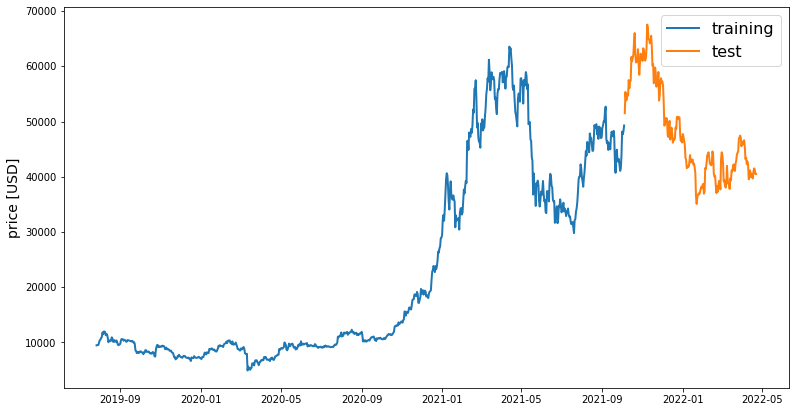

In [60]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [61]:
## Normalize the values
#====================================
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

Normalization is a technique often applied as part of data preparation for machine learning.

In [62]:
## Extract data 
#============================================
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [63]:
## Prepare the data
#============================================
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [64]:
##Building the LSTM model
#============================================
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [65]:
## Setting up some of the parameters to be used 
#===================================================
np.random.seed(42) # Makes the random numbers predictable
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100 # Increasing the network's depth lets it to learn a more powerful function from input to output.
epochs = 20
batch_size = 32
loss = 'mse' # Mean squared error (MSE) is the most commonly used loss function for regression.
dropout = 0.2
optimizer = 'adam' # Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.

In [66]:
## Train the model using inputs x_train and labels y_train
#=============================================================
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [67]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/20
25/25 [==============================] - 3s 27ms/step - loss: 0.0060 - val_loss: 0.0057
Epoch 2/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0049 - val_loss: 0.0022
Epoch 3/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0041 - val_loss: 0.0020
Epoch 4/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0026
Epoch 5/20
25/25 [==============================] - 0s 5ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 6/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 7/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0027 - val_loss: 0.0019
Epoch 8/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 9/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0023 - val_loss: 0.0016
Epoch 10/20
25/25 [==============================] - 0s 6ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 11/20
25/25 

The evaluation statistic I used is Mean Absolute Error (MAE). MAE is preferred over Root Mean Squared Error (RMSE) because it is more interpretable. Because RMSE does not only convey average error, it is significantly more difficult to comprehend.

# Mean Absolute Error
It measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between actual and predicted observations where all individual differences have equal weight.

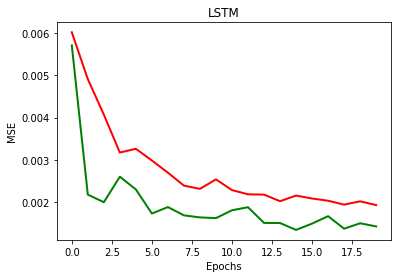

In [68]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [69]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.02828603976896899

The MAE value obtained looks good. 

In [70]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE


0.0014361100338639461

In [71]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.690062685813517

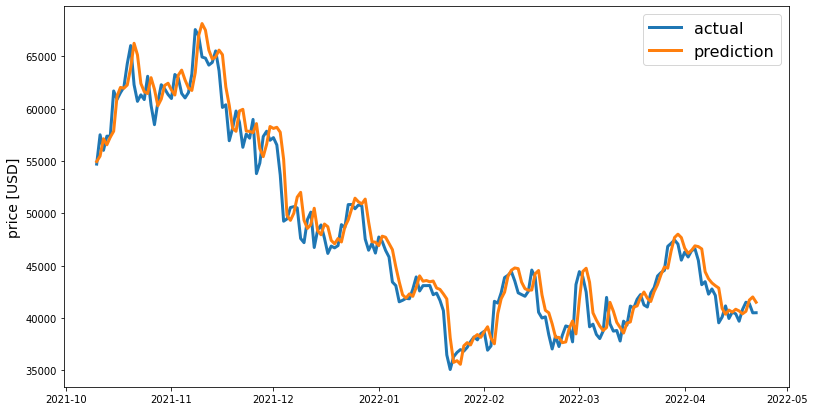

In [72]:
## Plot the actual and predicted prices 
#=========================================
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

We can use the LSTM neural network in this project to predict cryptocurrency prices in real time. Here I have used  a four-step process that included gathering real-time cryptocurrency data, preparing data for training and testing, implementing an LSTM neural network to predict prices, and visualising the findings.